**Chapter 2 – End-to-end Machine Learning project**

# Contents
1. Get the data
2. Data analysis
3. Data preparation
4. Select and train a couple of models
5. Evaluate the models on the test set


Your task is to predict median house values in Californian districts, given a number of features from these districts. A district typically has a population of 600 to 3000 people.

This is a regression task, since you are asked to predict a numerical value.

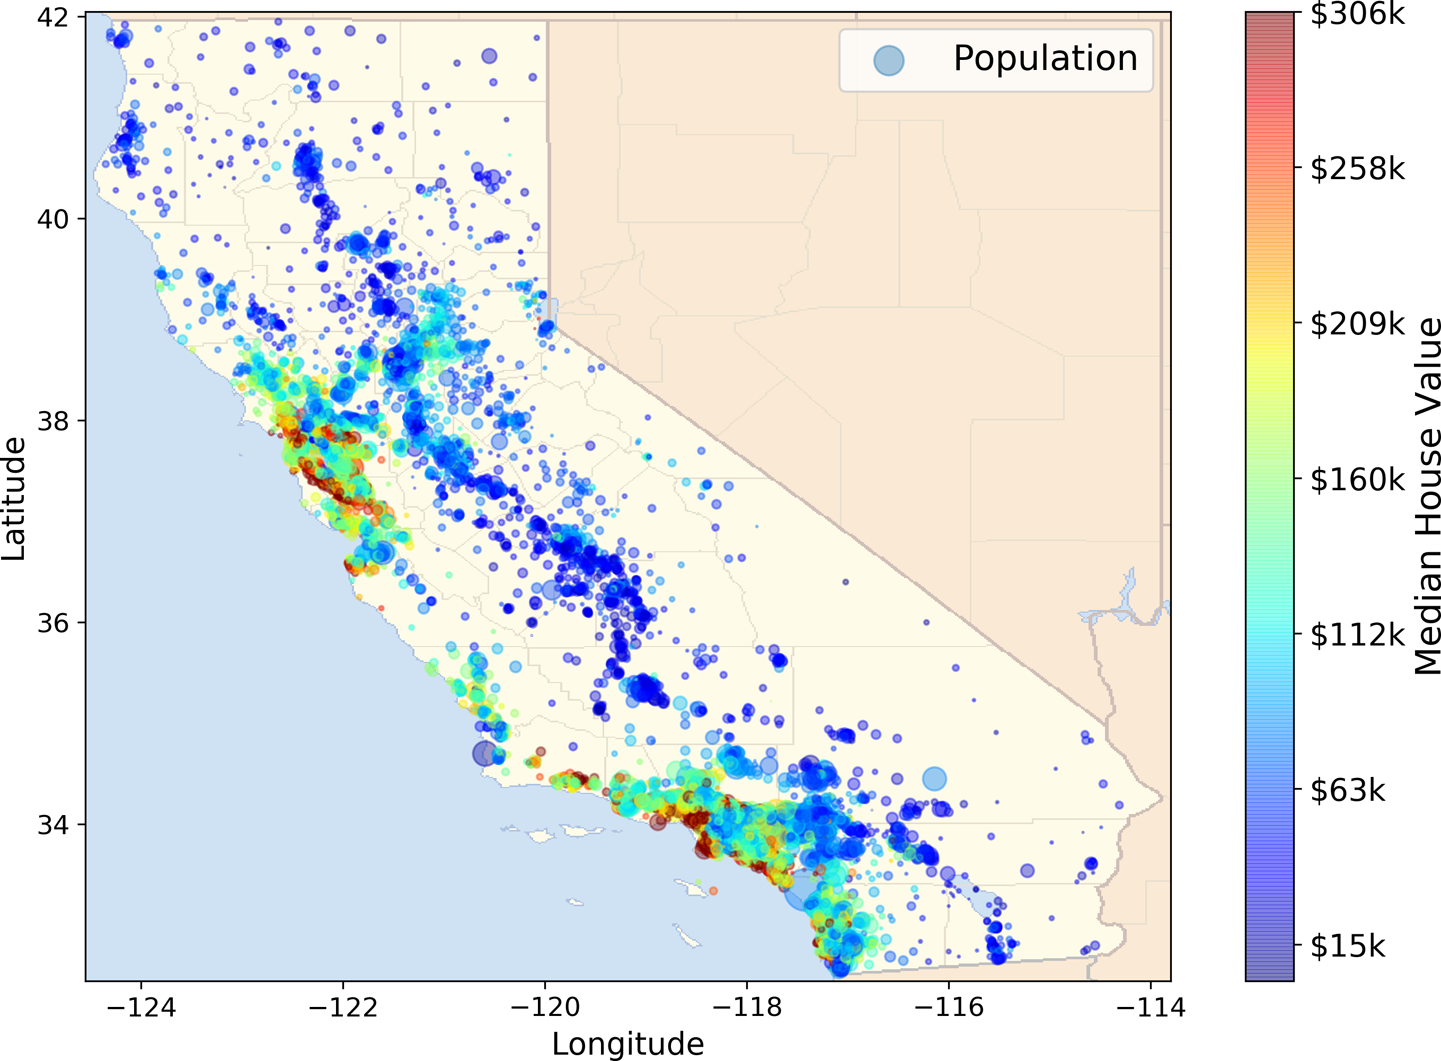

## Setup

In [3]:
# Common imports
import sklearn
import numpy as np

# Import the SSL module and configure certificate verification to be optional to avoid SSLCertVerificationError.
import ssl
ssl.SSLContext.verify_mode = ssl.VerifyMode.CERT_OPTIONAL

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [5]:
# This function creates a dataset/housing directory subdirectory, if it doesn't already exists. Then it downloads 
# the housing.tgz file, and extracts the housing.csv file.

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [6]:
# Display the top five rows
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# Get a quick description of the data
# (look for null values and non-numerical data which require special data preparation)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# Look at the non-numerical feature, ocean_proximity
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
# Display basic statistics for the features
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


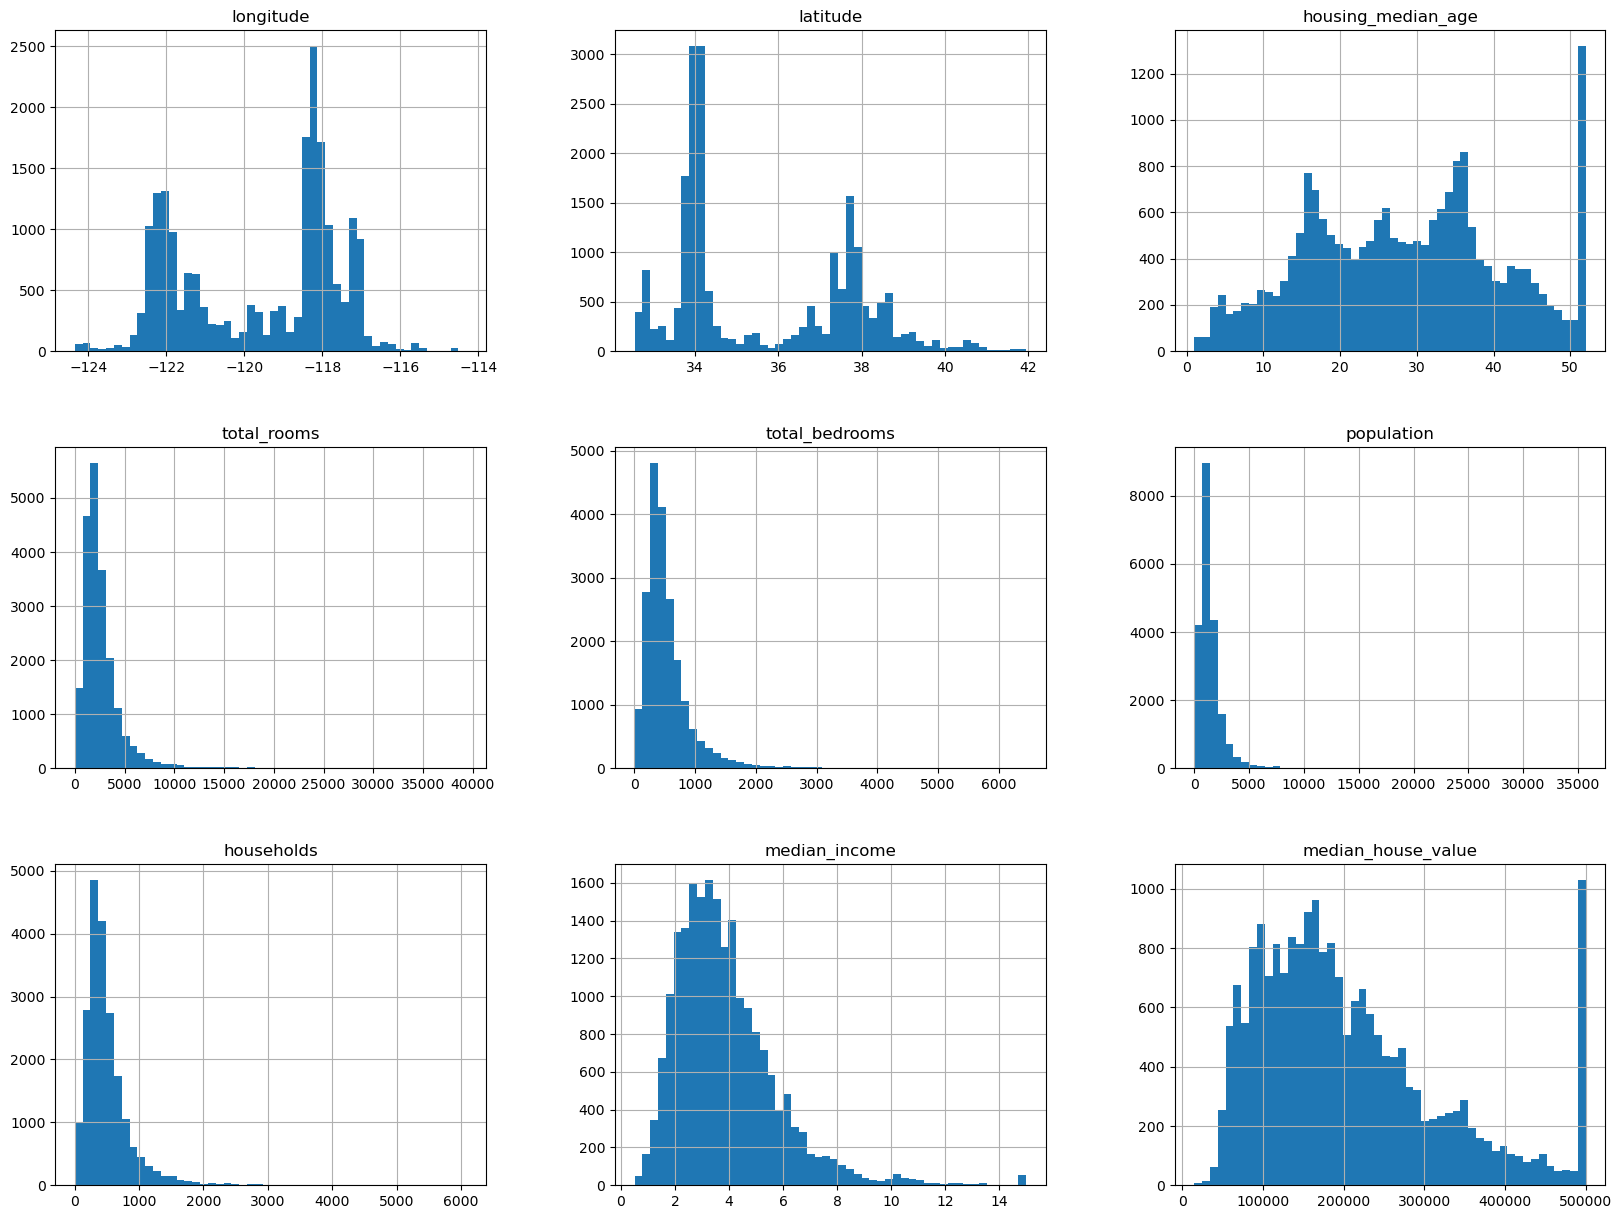

In [10]:
# Plot a histogram of each numerical feature
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Observations in the histograms
1) housing_median_age, median_house_value and median_income have been capped. If this is a problem, we could
   remove the largest values (we will omit that here for simplicity)
2) median_income has been scaled to tens of thousand dollars.
3) Some histograms are tail-heavy (may be a problem for some algorithms). Although a feature can be made less
   tail-heavy by using simple techniques, such as replacing each value with its square root or the logarithm,
   we will omit that here for simplicity.
4) The features has different scales (scaling may be required)

# Data analysis

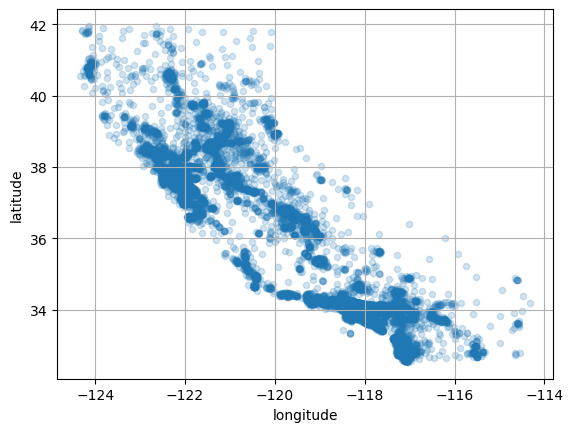

In [13]:
# Perform a geographical scatterplot of the data
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

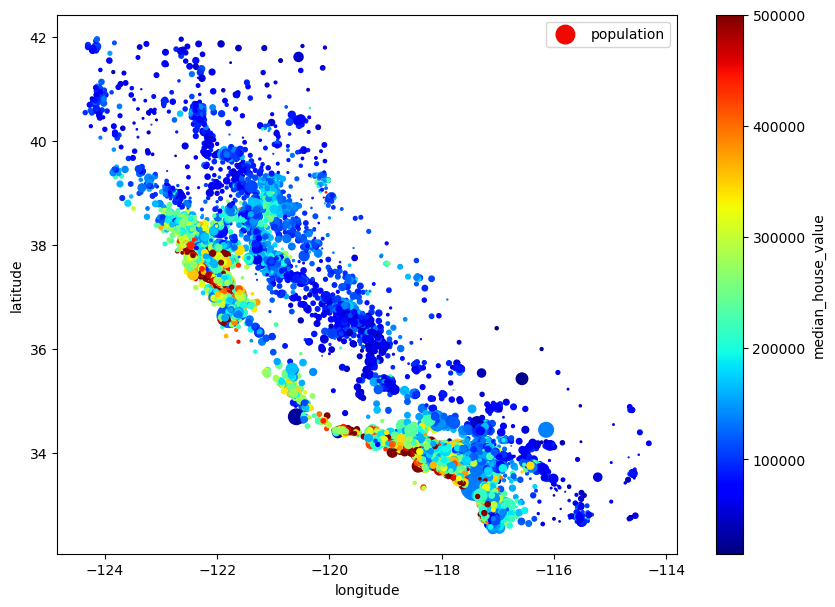

In [14]:
# A better visualization. The radius of each circle (option s) represents the district's population, and the
# color (option c) represents the price.
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10,7))
plt.show()

### Correlations
The plot above shows that the prices are much related to the location and the population density.

Let us now compute and illustrate linear correlations between selected attributes.

In [16]:
# How much does each feature correlate with the median house value?
# The correlation coefficient ranges from -1 (100% negative correlation) to 1 (100% positive correlation)
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### Attribute combinations
The total number of rooms in a district is not very useful. Instead, we want the number of rooms per household. Similarly, we want the number of bedrooms per room instead of the total number of bedrooms in a district, and the population per household instead of the total population in a district.

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
# How much does each of the new attributes correlate with the median house value?
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [20]:
# We will keep the new attributes and delete the original ones.
housing = housing.drop(columns="total_rooms")
housing = housing.drop(columns="total_bedrooms")
housing = housing.drop(columns="population")

# Data preparation

<ol>
<li>how to split the dataset in a training set and a test set</li>
<li>how to clean the data so that there are no missing values</li>
<li>how to re-scale attribute values</li>
<li>and how to handle a non-numerical feature</li>
</ol>

## Split the dataset

In [22]:
# Split the dataset randomly in training set (80%) and test set (20%). Use a fixed random seed (42).
# As a rule of thumb, pick 20% for the test set, unless the dataset is very large.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### stratified sampling
Random sampling is fine, if the dataset is large enough. If not, stratified sampling should be considered. Stratified sampling ensures that the test set is representative of the whole dataset. The dataset is first divided into subgroups called strata (e.g. a stratum could represent an income group). Then the right number of instances for both training and test sets are picked from each stratum. Stratified sampling reduces sampling bias.

In [24]:
# Remove the labels from the training set (the method returns a new set, and it does not affect the original one).
housing_predictors = train_set.drop(columns="median_house_value")
# Keep the labels in a separate set.
housing_labels = train_set["median_house_value"].copy()

## Data cleaning

Strategies:
<ol>
<li>Remove all rows with missing values. Use the DataFrame's dropna() method.</li>
<li>Remove all columns with missing values.</li>
<li>Replace missing values with some default value (mean, median, most frequent or some fixed value). Use Scikit-Learn's SimpleImputer class.</li>
</ol>

In [26]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [27]:
# Remove the text attribute because median can only be calculated on numerical attributes.
housing_num = housing_predictors.select_dtypes(include=[np.number])

In [28]:
# Compute the median of each attribute.
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [29]:
# The result is stored in the statistics_ instance variable.
imputer.statistics_

array([-1.18490000e+02,  3.42500000e+01,  2.90000000e+01,  4.11000000e+02,
        3.52460000e+00,  5.23242240e+00,  2.03058929e-01,  2.81956622e+00])

In [30]:
# Replace missing values with the medians.
imputer.transform(housing_num)

array([[-117.22      ,   32.75      ,   34.        , ...,    5.59794776,
           0.18513581,    2.47574627],
       [-117.03      ,   32.69      ,   10.        , ...,    5.39520958,
           0.1809101 ,    4.17964072],
       [-122.27      ,   37.74      ,   28.        , ...,    4.65566038,
           0.22492401,    2.00404313],
       ...,
       [-119.33      ,   36.28      ,   16.        , ...,    5.04615385,
           0.20083841,    2.07115385],
       [-117.19      ,   34.08      ,   22.        , ...,    4.99392713,
           0.2249696 ,    3.17206478],
       [-118.86      ,   34.22      ,   22.        , ...,    6.30769231,
           0.16260163,    3.45128205]])

In [31]:
# Scikit-Learn transformers returns NumPy arrays even when they get a Pandas DataFrame as input.
housing_num_numpy = imputer.transform(housing_num)

# If you want, you can wrap the returned NumPy array in a DataFrame, with the following code:
housing_dataframe = pd.DataFrame(housing_num_numpy, columns=housing_num.columns, index=housing_num.index)
housing_dataframe.head()

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
14196,-117.22,32.75,34.0,1072.0,4.5878,5.597948,0.185136,2.475746
8267,-117.03,32.69,10.0,167.0,4.6648,5.395210,0.180910,4.179641
17445,-122.27,37.74,28.0,1484.0,3.6875,4.655660,0.224924,2.004043
14265,-121.82,37.25,25.0,650.0,5.1663,6.186154,0.157672,3.350769
2271,-115.98,33.32,8.0,24.0,1.4688,10.000000,0.191667,2.625000


In [32]:
# You can also convert a Pandas DataFrame to a numpy array with the following code:
housing_dataframe.to_numpy()

array([[-117.22      ,   32.75      ,   34.        , ...,    5.59794776,
           0.18513581,    2.47574627],
       [-117.03      ,   32.69      ,   10.        , ...,    5.39520958,
           0.1809101 ,    4.17964072],
       [-122.27      ,   37.74      ,   28.        , ...,    4.65566038,
           0.22492401,    2.00404313],
       ...,
       [-119.33      ,   36.28      ,   16.        , ...,    5.04615385,
           0.20083841,    2.07115385],
       [-117.19      ,   34.08      ,   22.        , ...,    4.99392713,
           0.2249696 ,    3.17206478],
       [-118.86      ,   34.22      ,   22.        , ...,    6.30769231,
           0.16260163,    3.45128205]])

## Feature scaling
Most ML algorithms don't perform well, when the numerical input attributes have different scales. They tend to focus more on features with a large range of values, and less on features with a small range of values. There are two common  ways of scaling:

Min-max scaling (also called normalization): values are rescaled so that they end up ranging from 0 to 1.
Standardization: values are rescaled so that they have zero mean and unit variance.

Standardization is much less affected by outliers, but the lack of a fixed range (0 to 1) is a problem for some algorithms (e.g. neural networks).

Scaling the target values is generally not required.

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
housing_num_scaled = scaler.fit_transform(housing_num)
housing_num_scaled

array([[0.71015936, 0.02231668, 0.64705882, ..., 0.0333928 , 0.09459535,
        0.0014352 ],
       [0.72908367, 0.01594049, 0.17647059, ..., 0.03195514, 0.08990011,
        0.00280639],
       [0.20717131, 0.55260361, 0.52941176, ..., 0.02671086, 0.13880446,
        0.0010556 ],
       ...,
       [0.5       , 0.39744952, 0.29411765, ..., 0.02947992, 0.11204268,
        0.00110961],
       [0.71314741, 0.16365569, 0.41176471, ..., 0.02910958, 0.13885511,
        0.00199555],
       [0.54681275, 0.17853348, 0.41176471, ..., 0.03842572, 0.06955736,
        0.00222025]])

## Handling non-numerical features

In [36]:
# Extract the single non-numerical attribute, which is categorial.
housing_cat = housing_predictors[["ocean_proximity"]]

# Show the different categories.
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7313
INLAND             5276
NEAR OCEAN         2091
NEAR BAY           1827
ISLAND                5
Name: count, dtype: int64

In [37]:
# Create one binary attribute per category.
# It is called one-hot encoding, because only one attribute value will be 1 (hot) while the others will be 0 (cold).
# The default output is a sparse matrix, which only stores the location of the non-zero elements. Here we will use
# a dense matrix (sparse=False), since there are only a few categories.
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

# Other ways of converting a categorical attribute:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [38]:
# The original categories are stored in the categories_ instance variable.
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Transformation pipelines
The Scikit-Learn Pipeline class can perform a sequence of transformations.

In [40]:
# Pipeline for the numerical attributes.

# Create a Pipeline object and pass the desired sequence of data preparation
# tasks (also called "transformers") as constructor parameters.
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('minmax_scaler', MinMaxScaler()),
    ])

# Another way to create a Pipeline is to call the make_pipeline() method, where
# we pass the desired sequence of transformers as unnamed parameters.
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

housing_num_transformed = num_pipeline.fit_transform(housing_num)

In [41]:
# Pipeline for the categorical attribute.
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse_output=False))

In [42]:
# Pipeline that will transform both the numerical and categorial attributes and combine them.
from sklearn.compose import ColumnTransformer

# We must pass the names of the attributes which should be transformed
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

preprocessing_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

# Alternative construct:
#from sklearn.compose import make_column_selector, make_column_transformer

#preprocessing_pipeline = make_column_transformer(
#    (num_pipeline, make_column_selector(dtype_include=np.number)),
#    (cat_pipeline, make_column_selector(dtype_include=object)),
#)

housing_predictors_prepared = preprocessing_pipeline.fit_transform(housing_predictors)

In [43]:
housing_predictors_prepared

array([[0.71015936, 0.02231668, 0.64705882, ..., 0.        , 0.        ,
        1.        ],
       [0.72908367, 0.01594049, 0.17647059, ..., 0.        , 0.        ,
        1.        ],
       [0.20717131, 0.55260361, 0.52941176, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5       , 0.39744952, 0.29411765, ..., 0.        , 0.        ,
        0.        ],
       [0.71314741, 0.16365569, 0.41176471, ..., 0.        , 0.        ,
        0.        ],
       [0.54681275, 0.17853348, 0.41176471, ..., 0.        , 0.        ,
        0.        ]])

In [44]:
# This method outputs the number of rows and columns in the dataset.
housing_predictors_prepared.shape

(16512, 13)

# Select and train a model 

In [46]:
# Train a DecisionTreeRegressor.
from sklearn.tree import DecisionTreeRegressor

# As can be seen below, the last element in a pipeline can be a predictor (DecisionTreeRegressor)
# while the preceeding elements (those in the preprocessing_pipeline) must be transformers.
tree_reg = make_pipeline(preprocessing_pipeline, DecisionTreeRegressor(random_state=42))
# The fit method runs the preprocessing_pipeline before it trains the DecisionTreeRegressor.
tree_reg.fit(housing_predictors, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_room',
                                                   'population_per_household']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

The preferred performance measure for regression problems is the Root Mean Square Error (RMSE):

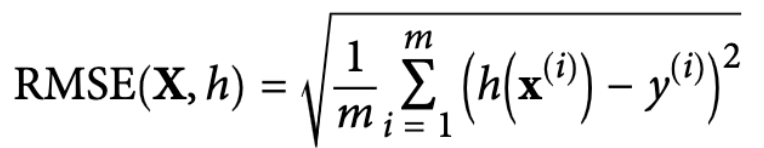

It measures the distance between the vector of predictions and the vector of target values.

<b>X</b> is a matrix containing all the features in the dataset, except labels.<br/>
h is the prediction function, also called a hypothesis.<br/>
m is the number of instances in the dataset.<br/>
<b>x</b>(i) is a vector of all the feature values, except the label, of the i'th instance in the dataset.<br/>
y(i) is the label of the i'th instance in the dataset.

In [48]:
# Measure the models RMSE on the training set
from sklearn.metrics import root_mean_squared_error

# We input the unprepared predictors of the training set to the predict method, because the predict method
# will run the preprocessing_pipeline on the input data, before making predictions.
housing_predictions = tree_reg.predict(housing_predictors)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

If there are many outliers in the dataset, you may consider using the Mean Absolute Error (MAE) instead:
    
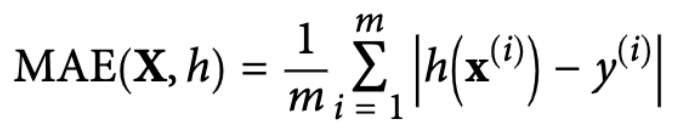

In [50]:
# Measure the models MAE on the training set
from sklearn.metrics import mean_absolute_error

tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

Observation:
No error at all? But maybe the model badly overfits the training data?
A better evaluation can be obtained using Cross-Validation, which we will not cover here.
We will just evaluate on the test set instead. This is okay, since we do not intend to fine-tune the model.

# Evaluate the model on the test set

In [53]:
# Remove the labels from the test set.
X_test = test_set.drop("median_house_value", axis=1)
# Keep the labels in a separate set.
y_test = test_set["median_house_value"].copy()

In [54]:
# Evaluate the DecisionTreeRegressor.
# Remember that the predict method will run the preprocessing_pipeline on X_test, before making predictions.
tree_reg_predictions = tree_reg.predict(X_test)
tree_reg_rmse = root_mean_squared_error(y_test, tree_reg_predictions)
tree_reg_rmse

72139.33884812282